# Part 1 - Feature Engineering

A great, and comprehensive, description of the dataset we will be using can be found [here](https://www.kaggle.com/c/PLAsTiCC-2018/data). 

#### The columns in the training set contain the following fields:
- **object_id** [int32]: Unique id that can be used to reference the metadata.
- **mjd** [float64]: the time in Modified Julian Date (MJD) of the observation.
- **passband** [int8]: The specific LSST passband integer, such that u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5 in which it was viewed.
- **flux** [float32]: the measured flux (brightness) in the passband of observation as listed in the passband column.
- **flux_err** [float32]: the uncertainty on the measurement of the flux listed above.
- **detected** [boolean]: If 1, the object's brightness is significantly different at the 3-sigma level relative to the reference template. Only objects with at least 2 detections are included in the dataset.

The first thing we can do is pin our GPU-based computations to a specific GPU. The `GPU_id` can be changed in order to use a different GPU. The instance in this tutorial uses 2x P40 GPUs, so you should be able to set `GPU_id` to `0` or `1`

In [24]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [25]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import seaborn as sns
from termcolor import colored
from cudf_workaround import cudf_groupby_aggs
import matplotlib.pyplot as plt
import warnings

In [26]:
warnings.filterwarnings("ignore")
sns.set()
print(gd.__version__)

0.9.0a+1077.g7ecea1c.dirty


<a id="global"></a>
## Global variables 

Here's the path to the dataset. *This is on a shared drive*

In [27]:
PATH = '/home/cjnolet/workspace/notebooks-extended/competition_notebooks/kaggle/plasticc/data'

We will be using Nvidia P40 cards for this tutorial, which have 24gb of memory. Our test set contains the most data, with over 19gb. In order to fit this on a single device, we will be subsampling from out test set. 

In [28]:
GPU_MEMORY = 24 # GB.

In [29]:
TEST_ROWS = 453653104 # number of rows in test data
# no skip if your gpu has 32 GB memory
# otherwise, skip rows porportionally
OVERHEAD = 1.2 # cudf 0.7 introduces 20% memory overhead comparing to cudf 0.4
SKIP_ROWS = int((1 - GPU_MEMORY/(32.0*OVERHEAD))*TEST_ROWS) 
GPU_RUN_TIME = {}

<a id="etl"></a>
## ETL & Visualizations

### Load data for ETL part 1
**GPU load data**

The first thing we will need to do is load the CSV files for our training and test datasets into Pandas DataFrames.

You can do this using the `read_csv` on the Pandas API, which cuDF also supports.

Below is the function header for the `read_csv` function. See if you can load the CSV files for the training and testing datasets into
variables named `train_dg` and `test_gd`.

```
pandas.read_csv(filepath_or_buffer, names=None, dtype=None, skiprows=None)
```

In [30]:
def load_train_test_csv(path):
    """
    Loads the CSV files for the test & train datasets into cuDFs
    """
    
    ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
    ts_dtypes = ['int32', 'float32', 'int8', 'float32','float32','int32']
    
    train_gd = gd.read_csv('%s/training_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)
    test_gd = gd.read_csv('%s/test_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS)
    
    return train_gd, test_gd

In [31]:
train_gd, test_gd = load_train_test_csv(PATH)

Let's look at the contents of the first row

In [32]:
train_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.421875,2,-544.810303,3.622952,1
1,615,59750.429688,1,-816.434387,5.553370,1
2,615,59750.437500,3,-471.385498,3.801213,1
3,615,59750.441406,4,-388.984955,11.395031,1
4,615,59752.406250,2,-681.858826,4.041203,1


### Visualizations

Let's visualize the flux for different passbands at different times for a few different objects in our data set.

In [33]:
def scatter(x,y,values,xlabel='x',ylabel='y',title=None):
    """
    Builds a scatter plot specific to the LSST data format by plotting 
    the flux over time for different passbands for a single object.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = np.array([colors[i] for i in values])
    ps = []
    bs = []
    bands = ['passband_%s'%i for i in ['u', 'g', 'r', 'i', 'z','y']]
    for i in sorted(np.unique(values)):
        mask = values==i
        if len(x[mask]):
            p = plt.scatter(x[mask],y[mask],c=colors[mask])
            ps.append(p)
            bs.append(bands[i])
    plt.legend(ps,bs,scatterpoints=1)
    if title is not None:
        plt.title(title)
    
    plt.xlim([np.min(x)-10,np.min(x)+1500])
    plt.ylabel('y: %s'%ylabel)
    plt.xlabel('x: %s'%xlabel)

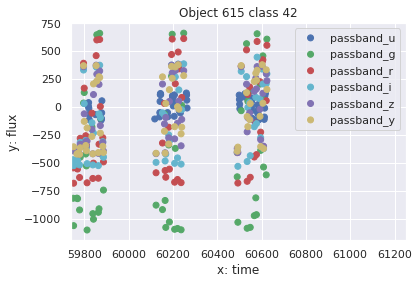

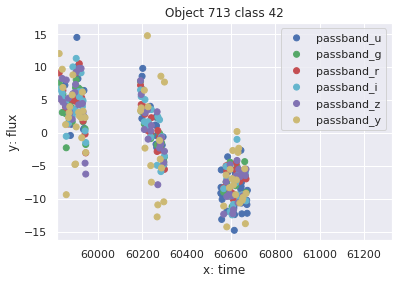

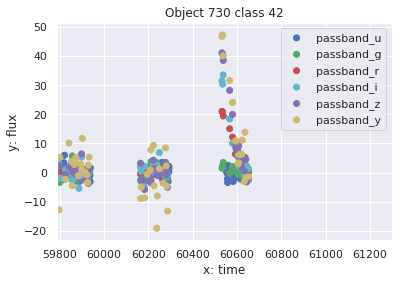

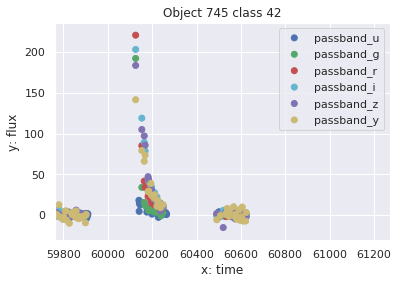

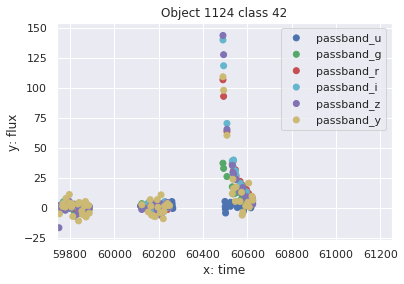

In [34]:
n_objects = 5

for oid in train_gd.object_id.unique()[:n_objects]:
    train = train_gd.to_pandas()
    mask = train.object_id== oid

    scatter(train.loc[mask,'mjd'].values,
            train.loc[mask,'flux'].values,
            values=train.loc[mask,'passband'].values,
            xlabel='time',
            ylabel='flux',
            title='Object %d class 42'%oid)
    plt.show()

### Perform ETL Pt 1 - Compute flux skewness for each object_id

To begin our ETL, we are going to compue the skewness across the flux for all times and sort the resulting dataframes by their ids. 

In [35]:
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

In [36]:
aggs = {'flux':['skew']}

test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs=aggs)
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs=aggs)

In [37]:
test_flux_skew_gd = test_gd.sort_values(by='object_id')
train_flux_skew_gd = train_gd.sort_values(by='object_id')

Let's print out the first row of the aggregated dataframe

In [38]:
train_flux_skew_gd.head().to_pandas()

,object_id,skew_flux
0,615,-0.349541
1,713,0.014989
2,730,3.177856
3,745,4.979831
4,1124,4.406288


### Perform ETL Pt 2 - Flux & timestamp summary statistics

We computed the flux skew in the previous ETL step and only kept those columns on GPU. Next we will need to load our original train & test CSV files back in so that we can do some additional aggregations.

In [16]:
train_gd, test_gd = load_train_test_csv(PATH)

Read in the training metadata fields

In [17]:
cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']

dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH, names=cols, dtype=dtypes, skiprows=1)

In [39]:
train_meta_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,1,1.8181,1.6267,0.2552,45.406303,0.007,88
2,730,1,0.2320,0.2262,0.0157,40.256100,0.021,42
3,745,1,0.3037,0.2813,1.1523,40.795101,0.007,90
4,1124,1,0.1934,0.2415,0.0176,40.416599,0.024,90


And the resulting testing metadata fields, excluding the `target` label field

In [18]:
# Remove the target field from the cols 
del cols[-1],dtypes[-1]

test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH, names=cols,dtype=dtypes,skiprows=1)

In [19]:
def groupby_aggs(df,aggs,col = "object_id"):
    """
    Given a Dataframe and a dict of {"field":"["agg", "agg"]"}, perform the 
    given aggregations using the given column as the groupby key. The original
    (non-aggregated) field is dropped from the dataframe. 
    """

    res = None
    for i,j in aggs.items():
        for k in j:
            tmp = df.groupby(col,as_index=False).agg({i:[k]})
            tmp.columns = [col,'%s_%s'%(k,i)]
            res = tmp if res is None else  res.merge(tmp,on=[col],how='left')
        df.drop_column(i)
    return res


def etl_gpu(df,df_meta):
    
    aggs = {
        'passband': ['mean'],  # mean passband
        'detected': ['mean'],  # mean detected
        'mjd':['max','min'],   # min / max time range
    }
    
    agg_df = groupby_aggs(df, aggs)
    
    # at this step, columns ['passband','detected','mjd'] are deleted 

    """
    If flux uncertanty is low, we get a high ratio squared. If the uncertaincy is high, 
    we will get a low ratio squared.
    """
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    
    aggs2 = {
        'flux_ratio_sq':['sum'],            # Sum the sq flux ratios
        'flux_by_flux_ratio_sq':['sum'],    # Sum the flux * sq flux ratios
        'flux': ['min', 'max', 'mean'],     # Summary stats for flux
        'flux_err': ['min', 'max', 'mean'], # Summary stats for flux certainty
    }
    
    agg_df2 = groupby_aggs(df, aggs2)
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

In [20]:
train_final_gd = etl_gpu(train_gd,train_meta_gd)
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')

test_final_gd = etl_gpu(test_gd,test_meta_gd)
del test_gd,test_meta_gd
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')

In [40]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,mean_flux,min_flux_err,max_flux_err,mean_flux_err,flux_diff,flux_dif2,flux_w_mean,flux_dif3,mjd_diff,skew_flux
0,39420562,0,0.1400,0.1440,0.1291,39.169300,0.125,15,3.161074,0.020134,...,4.812441,2.030897,78.555534,17.274602,235.335602,48.901504,58.419159,4.028398,1090.023438,1.689423
1,39446441,0,0.3628,0.4729,0.0922,42.116398,0.058,15,3.264000,0.048000,...,8.521700,1.610613,43.066505,13.048977,260.390259,30.556139,164.063095,1.587135,1079.050781,3.215945
2,39488530,0,0.2935,1.4029,0.4197,45.009701,0.052,15,2.967742,0.016129,...,3.117172,1.593112,69.034836,11.826147,114.494293,36.730182,28.208735,4.058824,898.699219,0.679230
3,39501380,0,0.2130,0.2166,0.0082,40.150097,0.105,52,2.933884,0.049587,...,5.297180,1.767563,61.292171,12.513084,218.538284,41.255592,71.603760,3.052050,907.628906,1.891616
4,39511222,0,0.0000,0.0000,0.0000,NaN,0.011,6,2.992481,0.105263,...,17.711097,2.380389,45.077370,12.902521,323.815430,18.283194,154.929977,2.090076,900.734375,3.166074


Store our extracted data out to csv files so that we can use it downstream 

In [22]:
train_final_gd.to_csv("train_gdf.csv")
test_final_gd.to_csv("test_gdf.csv")